In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

## Load the conservation tracks

### Window averages

In [2]:
files <- list.files("../clean_data/annotations", pattern="*.bed$", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

### Load a subset of annotation tracks used by CADD

In [3]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, priPhCons, Consequence, AnnoType)
)

Warning message:
"673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
"

### Merge both annotation data sets (homemade window-based and CADD subset)

In [4]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [5]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "bval__100000bp"           "bval__10000bp"           
 [3] "bval__25000bp"            "bval__50000bp"           
 [5] "exon_density__100000bp"   "exon_density__10000bp"   
 [7] "exon_density__200000bp"   "exon_density__25000bp"   
 [9] "exon_density__50000bp"    "exon_distance"           
[11] "phyloP_nohuman__100000bp" "phyloP_nohuman__10000bp" 
[13] "phyloP_nohuman__25000bp"  "phyloP_nohuman__50000bp" 
[15] "priPhCons__100000bp"      "priPhCons__10000bp"      
[17] "priPhCons__25000bp"       "priPhCons__50000bp"      
[19] "priPhyloP__100000bp"      "priPhyloP__10000bp"      
[21] "priPhyloP__25000bp"       "priPhyloP__50000bp"      
[23] "bStatistic"               "priPhCons"               
[25] "Consequence"              "AnnoType"

## Load the SNP data

In [6]:
suppressMessages({

# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                       "../clean_data/sgdp.tsv",
                       "../clean_data/archaics.tsv",
                       filter_damage=TRUE, # remove potential aDNA substitutions (C->T, G->A)
                       metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
    inner_join(all_annots_wide)

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(!(pop == "Oceania" & Country != "PapuaNewGuinea")) %>%
  mutate(pop=ifelse(pop == "Oceania", "Papua", pop)) %>%
  filter(pop != "Papua")

emh_info <-
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH") %>%
  filter(name %in% colnames(all_snps),
  #       name != "Oase1")
         ! name %in% c("Continenza", "Kostenki12", "Ostuni2",
                       "Pavlov1", "Vestonice15", "Vestonice43",
                       "Vestonice13", "Oase1", "Muierii2",
                       "AfontovaGora2"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age,
         name=factor(name, levels=name),
         pop=as.factor(pop)) %>% 
  select(-c(Country, Latitude, Longitude))

})

Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"Warning message in one_of(sgdp_info$name):
"Unknown variables: `S_Australian_1`, `S_Australian_5`"Warning message:
"Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]"

## Specify conserved/neutral annotation bins

5%      95% 
0.065137 0.190970

2%       98% 
0.0540150 0.2183012

1%        99% 
0.04460688 0.24103436

0.5%      99.5% 
0.03628488 0.26427624

Warning message:
"Removed 14 rows containing non-finite values (stat_bin)."

Warning message:
"Removed 14 rows containing non-finite values (stat_bin)."

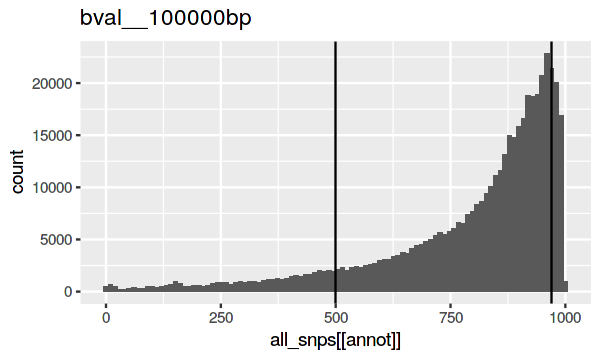

Warning message:
"Removed 14 rows containing non-finite values (stat_bin)."

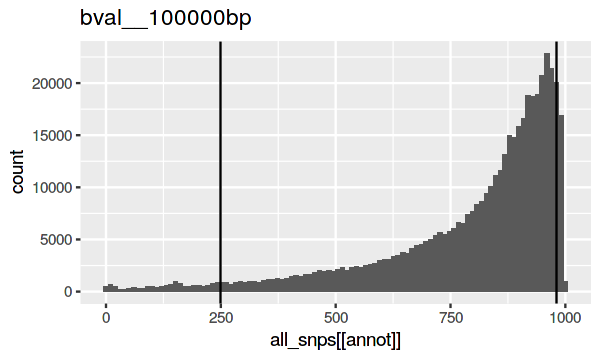

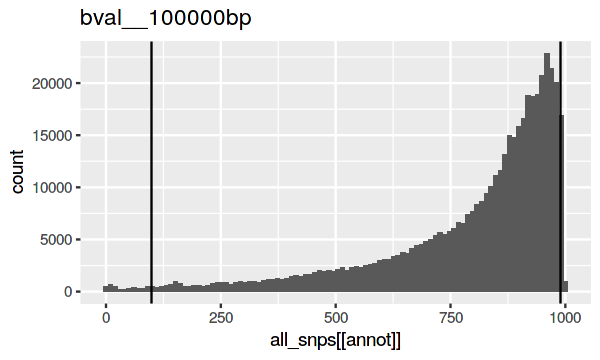

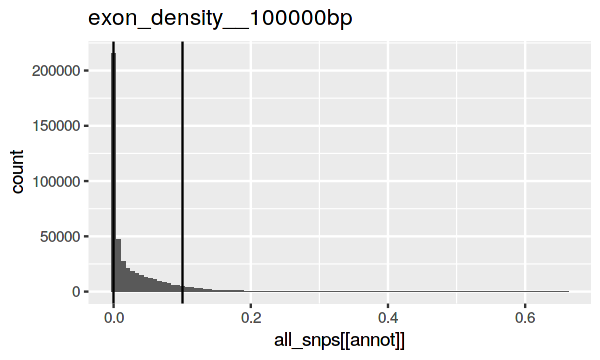

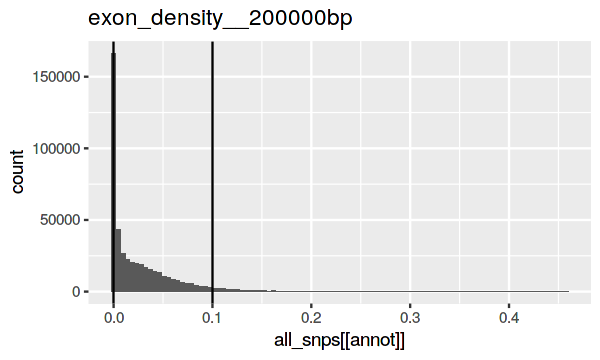

Warning message:
"Removed 308 rows containing non-finite values (stat_bin)."

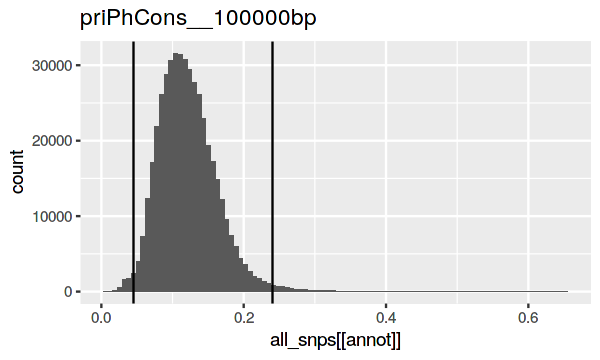

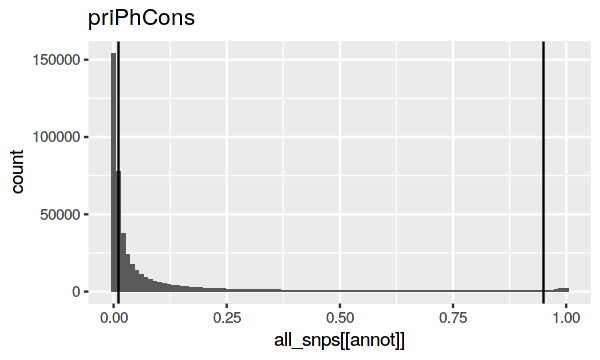

In [7]:
options(repr.plot.width=5, repr.plot.height=3)

plot_annot <- function(annot, low, high) {
  qplot(all_snps[[annot]], bins=100) +
      geom_vline(xintercept=c(low, high)) +
      ggtitle(annot)
}

# specify lower and upper cut-offs for conserved and neutral regions
(q5 <- quantile(all_snps$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE))
(q2 <- quantile(all_snps$priPhCons__100000bp, probs=c(0.02, 0.98), na.rm=TRUE))
(q1 <- quantile(all_snps$priPhCons__100000bp, probs=c(0.01, 0.99), na.rm=TRUE))
(q0 <- quantile(all_snps$priPhCons__100000bp, probs=c(0.005, 0.995), na.rm=TRUE))

priPhCons_low    <- 0.01;  priPhCons_high    <- 0.95
b_100k_low       <- 500;   b_100k_high       <- 970
b_100k_low2      <- 250;   b_100k_high2      <- 980
b_100k_low3      <- 100;   b_100k_high3      <- 990
density_100k_low <- 0;     density_100k_high <- 0.1
density_200k_low <- 0;     density_200k_high <- 0.1
priPhCons_q5_low <- q5[1]; priPhCons_q5_high <- q5[2]
priPhCons_q2_low <- q2[1]; priPhCons_q2_high <- q2[2]
priPhCons_q1_low <- q1[1]; priPhCons_q1_high <- q1[2]
priPhCons_q0_low <- q0[1]; priPhCons_q0_high <- q0[2]

# plot the distributions and the cut-off values
plot_annot("bval__100000bp",         b_100k_low,        b_100k_high)
plot_annot("bval__100000bp",         b_100k_low2,       b_100k_high2)
plot_annot("bval__100000bp",         b_100k_low3,       b_100k_high3)
plot_annot("exon_density__100000bp", density_100k_low, density_100k_high)
plot_annot("exon_density__200000bp", density_200k_low, density_200k_high)
plot_annot("priPhCons__100000bp",    priPhCons_q1_low, priPhCons_q1_high)
plot_annot("priPhCons",              priPhCons_low,    priPhCons_high)

## Divide SNPs into conserved/neutral bins based on different annotations

In [8]:
#
# Divide SNPs into two equal-sized bins (conserved and neutral)based
# on the given annotation.
#
bin_cons_neutral <- function(snps, stat,
                           low_cutoff, high_cutoff,
                           low_bin, high_bin, equalize=FALSE) {
  bins <- ifelse(snps[[stat]] <= low_cutoff, low_bin,
          ifelse(snps[[stat]] > high_cutoff, high_bin, NA))

  if (equalize) {
      # count the number of conserved and neutral elements
      counts <- table(bins)

      # get the bin with the highest number of snps
      max_bin <- names(counts)[which(counts == max(counts))]

      # make the counts of bin elements equal by removing a subset
      # of elements from the biggest of the two bins
      bins[sample(which(bins == max_bin), max(counts) - min(counts))] <- NA
  }

  factor(bins)
}

all_snps <-
  mutate(all_snps, # convert annotation types into numeric values for later binning
     genic=ifelse(AnnoType %in% c("CodingTranscript", "RegulatoryFeature"), 1,
           ifelse(AnnoType == "Intergenic", -1, NA)),
     coding=ifelse(AnnoType == "CodingTranscript", 1,
                   ifelse(AnnoType == "Intergenic", -1, NA))
     ) %>% 
  mutate( # bin SNPs into conserved/neutral regions based on different annotations
     annot_priPhCons =       bin_cons_neutral(., "priPhCons",              priPhCons_low,    priPhCons_high,    "neutral",   "conserved"),
     annot_bval_100k =       bin_cons_neutral(., "bval__100000bp",         b_100k_low,       b_100k_high,       "conserved", "neutral"),
     annot_bval_100k2 =      bin_cons_neutral(., "bval__100000bp",         b_100k_low2,      b_100k_high2,      "conserved", "neutral"),
     annot_bval_100k3 =      bin_cons_neutral(., "bval__100000bp",         b_100k_low3,      b_100k_high3,      "conserved", "neutral"),
     annot_genic=            bin_cons_neutral(., "genic",                  -1,               0,                 "neutral",   "conserved"),
     annot_coding=           bin_cons_neutral(., "coding",                 -1,               0,                 "neutral",   "conserved"),
     annot_priPhCons_100k_q5=bin_cons_neutral(., "priPhCons__100000bp",    priPhCons_q5_low, priPhCons_q5_high, "neutral",   "conserved"),
     annot_priPhCons_100k_q2=bin_cons_neutral(., "priPhCons__100000bp",    priPhCons_q2_low, priPhCons_q2_high, "neutral",   "conserved"),
     annot_priPhCons_100k_q1=bin_cons_neutral(., "priPhCons__100000bp",    priPhCons_q1_low, priPhCons_q1_high, "neutral",   "conserved"),
     annot_priPhCons_100k_q0=bin_cons_neutral(., "priPhCons__100000bp",    priPhCons_q0_low, priPhCons_q0_high, "neutral",   "conserved"),      
     annot_density_100k=     bin_cons_neutral(., "exon_density__100000bp", density_100k_low, density_100k_high, "neutral",   "conserved"),
     annot_density_200k=     bin_cons_neutral(., "exon_density__200000bp", density_200k_low, density_200k_high, "neutral",   "conserved")
  )

binned <- gather(all_snps, annot, region, starts_with("annot_")) %>%
  mutate(annot=str_replace(annot, "annot_", ""))

## Number of SNPs available for each annotation bin

In [9]:
binned %>%
    group_by(annot, region) %>%
    filter(region != "NA", str_detect(annot, "priPhCons")) %>%
    summarise(count=n())

annot,region,count
priPhCons,conserved,6974
priPhCons,neutral,202336
priPhCons_100k_q0,conserved,2315
priPhCons_100k_q0,neutral,2315
priPhCons_100k_q1,conserved,4630
priPhCons_100k_q1,neutral,4630
priPhCons_100k_q2,conserved,9259
priPhCons_100k_q2,neutral,9260
priPhCons_100k_q5,conserved,23147
priPhCons_100k_q5,neutral,23151


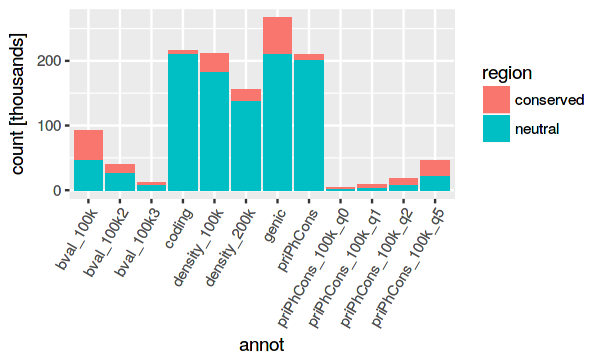

In [10]:
binned %>%
    group_by(annot, region) %>%
    filter(region != "NA") %>%
    summarise(count=n() / 1000) %>% 
    ggplot(aes(annot, count, fill=region)) +
        geom_bar(stat="identity") +
        labs(y="count [thousands]") +
        theme(axis.text.x=element_text(angle=60, hjust=1))

## Calculate Nea% in each conserved/neutral bin for all annotations

In [11]:
nea_cn <-
    samples_info %>%
    mutate(
        cons_vs_neutral=purrr::map(as.character(name), function(n) {
            select_(binned, "archaic_Altai", n, "annot", "region") %>%
                group_by(annot, region) %>%
                do(nea=calc_sharing_prop(., "archaic_Altai", n)) %>%
                unnest %>%
                filter(complete.cases(.))
        }),
        genome_wide=sapply(as.character(name), function(n) {
            calc_sharing_prop(all_snps, "archaic_Altai", n)
        }),
        missing=sapply(as.character(name), function(n) {
            mean(is.na(all_snps[[n]]))
        })
    )

In [12]:
filter(unnest(nea_cn), name %in% c("UstIshim", "French_1", "Sardinian_2", "English_1"), annot == "priPhCons_100k_q1")

name,age,pop,post_admixture,genome_wide,missing,annot,region,nea
UstIshim,45020,EMH,9980,0.02819661,0.6747993822,priPhCons_100k_q1,conserved,0.02481556
UstIshim,45020,EMH,9980,0.02819661,0.6747993822,priPhCons_100k_q1,neutral,0.05619499
English_1,0,WestEurasia,55000,0.01919009,0.0003326529,priPhCons_100k_q1,conserved,0.01533477
English_1,0,WestEurasia,55000,0.01919009,0.0003326529,priPhCons_100k_q1,neutral,0.03459459
French_1,0,WestEurasia,55000,0.01834190,0.0002700105,priPhCons_100k_q1,conserved,0.01101512
French_1,0,WestEurasia,55000,0.01834190,0.0002700105,priPhCons_100k_q1,neutral,0.03176318
Sardinian_2,0,WestEurasia,55000,0.02022699,0.0004255365,priPhCons_100k_q1,conserved,0.01166307
Sardinian_2,0,WestEurasia,55000,0.02022699,0.0004255365,priPhCons_100k_q1,neutral,0.03780514


## Ratios of Nea% in the most conserved vs most neutral regions

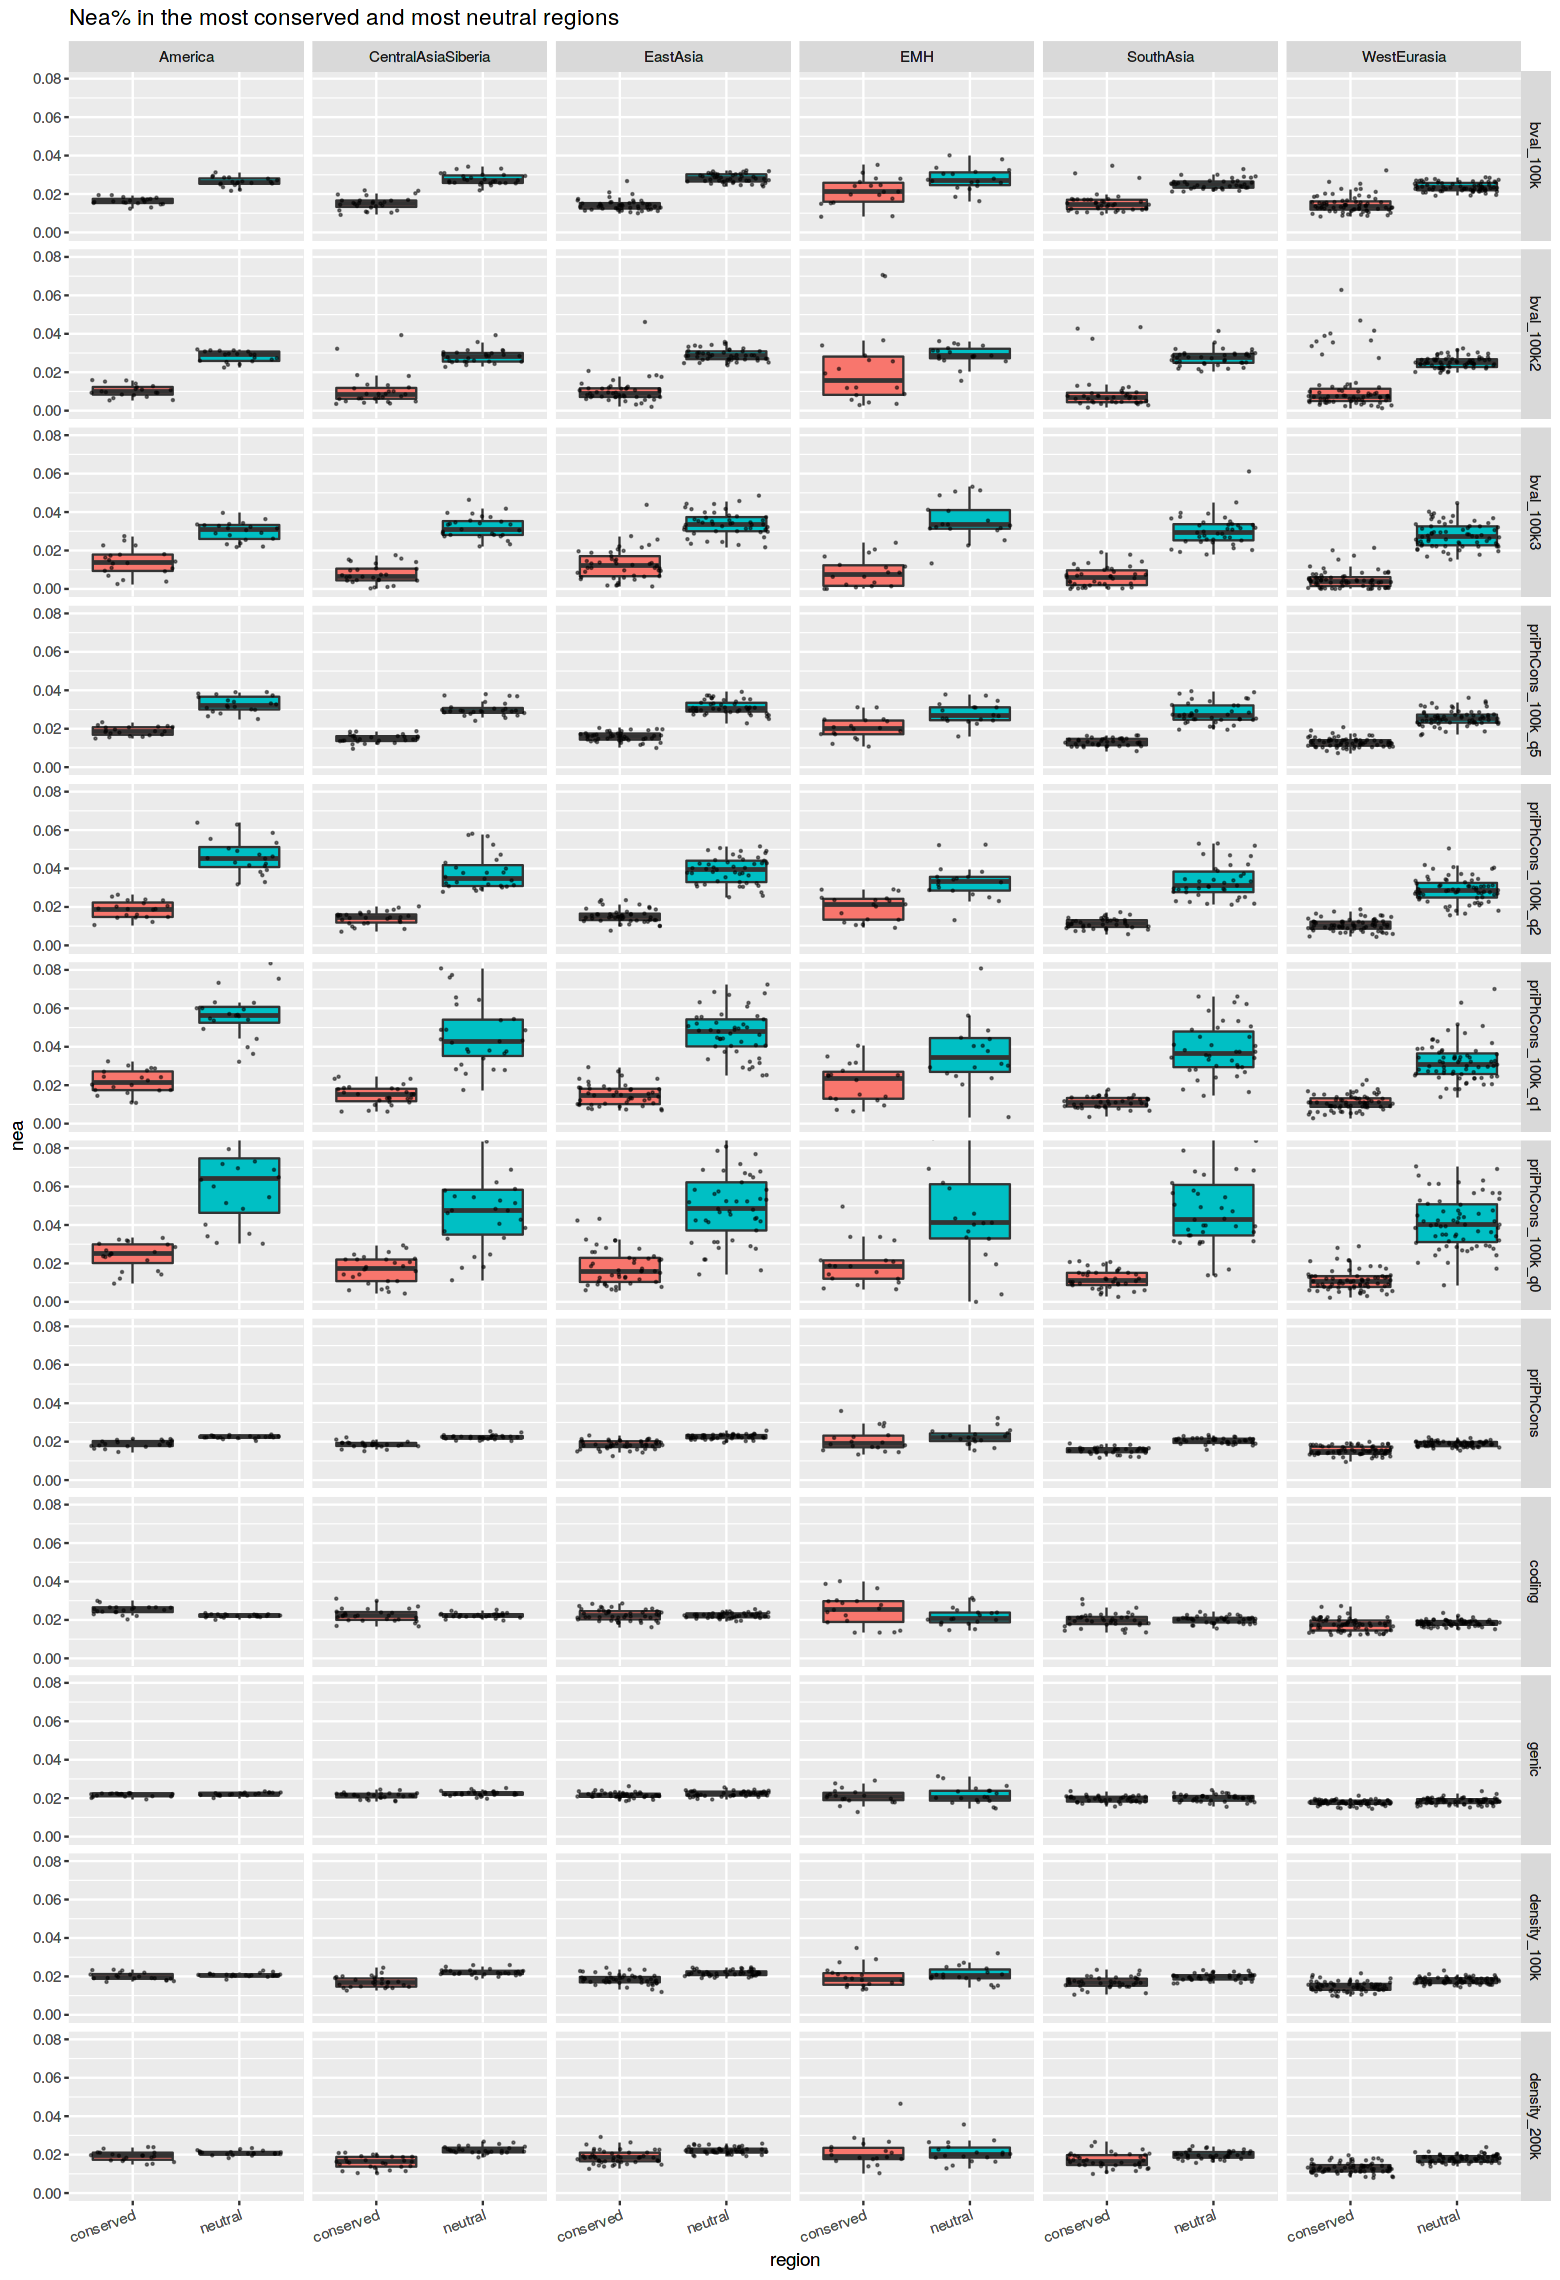

In [13]:
options(repr.plot.width=13, repr.plot.height=19)

unnest(nea_cn) %>% filter(!pop %in% c("Africa", "Papua")) %>%
  mutate(annot=factor(annot, levels=c("bval_100k", "bval_100k2", "bval_100k3",
                                      paste0("priPhCons_100k_q", c(5, 2, 1, 0)),
                                      "priPhCons",
                                      "coding", "genic",
                                      "density_100k", "density_200k"))) %>%
  ggplot(aes(region, nea, fill=region)) +
  geom_boxplot(outlier.shape=NA) +
  geom_jitter(alpha=1/2, size=0.2) +
  facet_grid(annot ~ pop, scales="free_y") +
  ggtitle("Nea% in the most conserved and most neutral regions") +
  coord_cartesian(ylim=c(0, 0.08)) +
  theme(axis.text.x=element_text(angle=20, hjust=1), legend.position="none")

**Notes**

Diffferent Nea% in superneutral regions might indicate different amounts of Nea. admixture.

Differences between populations are much bigger in superneutral regions, but more similar in conserved regions. Does this mean that Nea. alleles were selected against with a similar selection strength? This would make sense, because they were.

Also, if there were multiple admixture "pulses" from different Nea. populations, perhaps these populations had different population histories and, as a consequence, different genetic burdens of deleterious variation? Alternatively, if the early non-African population was structured (different $N_e$ and different efficacy of selection), they would have a slightly higher Nea. ancestry in very conserved regions (Nea. alleles would be nearly drifting) than in populations with higher $N_e$ (Nea. allele frequencies would be pushed down).

window-based priPhCons shows higher Nea% in neutral regions compared to B values, but different pattern for conserved regions --> B values as a better measure of conservation, but priPhCons better distinguishes neutral regions?

Different results for "raw" priPhCons and window-average priPhCons - the former requires the informative site from the array to be the deleterious allele that potentially disrupted the conserved region function. The latter captures the potential effect of an unobserved deleterious Nea. allele on the linked (potentially neutral) allele on the archaic admixture array.

Not only is the hypothesis of Juric and Harris incompatible with codingVSintergenic results and the simulated trajectories. But the magnitude of the difference for windowed priPhCons seems to require a _much_ stronger selection. Even the originaly B value results predict a higher difference.

In [14]:
arrange(filter(nea_cn, age > 0), age) %>% unnest %>% distinct(name, age, missing, genome_wide)

name,age,missing,genome_wide
Stuttgart,7140,0.6774304,0.01905821
Motala12,7625,0.7251380,0.01963912
Hungarian_KO1,7660,0.8158377,0.01847356
LaBrana1,7815,0.7294689,0.02274016
Loschbour,8050,0.6759853,0.02245985
Karelia,8375,0.7527201,0.02044952
Kotias,9720,0.6751212,0.01545867
Satsurblia,13255,0.7733122,0.01603712
Bichon,13665,0.6783916,0.02278238
Villabruna,13980,0.8213459,0.02068749


## Nea% in conserved/neutral regions per individual

In [15]:
binned %>%
    group_by(annot, region) %>%
    filter(annot == "priPhCons_100k_q1", region == "neutral") %>%
    .[["Bengali_1"]] %>% 
    sum(!is.na(.), na.rm = T)

[1] 5204

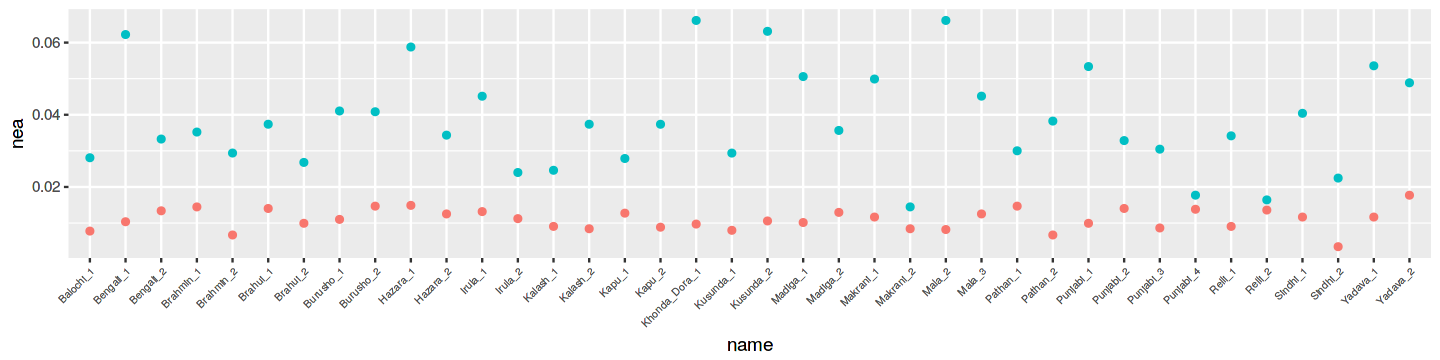

In [16]:
options(repr.plot.width=12, repr.plot.height=3)

filter(nea_cn, pop == "SouthAsia") %>% unnest %>% filter(str_detect(annot, "q1")) %>% 
ggplot(aes(name, nea, group=region, color=region)) +
    geom_point() +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=6), legend.position="none")

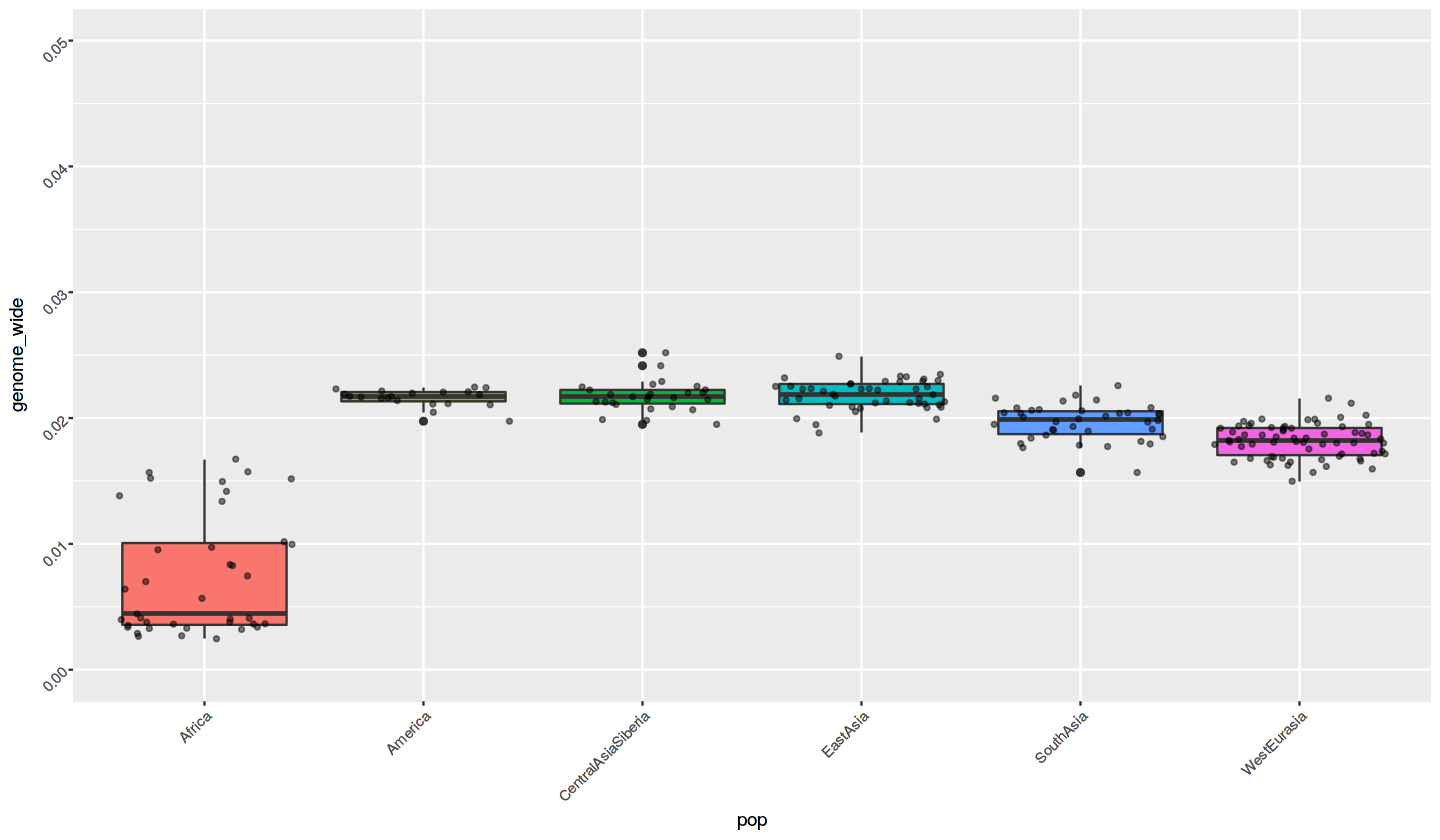

In [17]:
options(repr.plot.width=12, repr.plot.height=7)

filter(nea_cn, pop != "EMH") %>%
ggplot() +
  geom_boxplot(aes(pop, genome_wide, fill=pop)) +
  geom_jitter(aes(pop, genome_wide), size=1, alpha=1/2) +
  coord_cartesian(ylim=c(0, 0.05)) +
  theme(axis.text=element_text(angle=45, hjust=1), legend.position="none")

## T-test of distribution of Nea% in conserved vs neutral regions

## Nea% vs time in conserved/neutral regions

Warning message:
"Removed 10 rows containing non-finite values (stat_smooth)."Warning message:
"Removed 10 rows containing missing values (geom_point)."

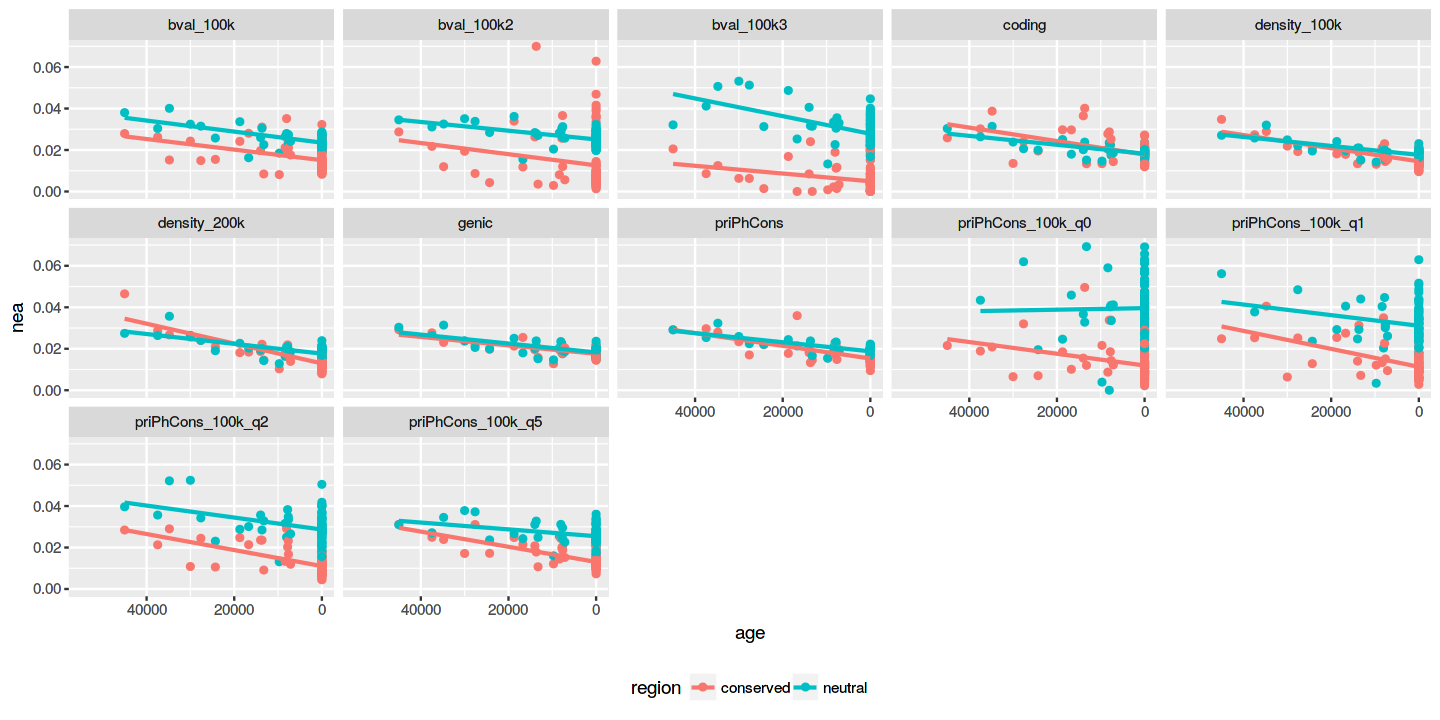

In [18]:
options(repr.plot.width=12, repr.plot.height=6)

nea_cn %>%
  filter(pop %in% c("EMH", "WestEurasia")) %>%
  unnest %>%
  ggplot(aes(age, nea, color=region)) +
  geom_point() +
  geom_smooth(method="lm", se=FALSE, size=0.9) +
  facet_wrap( ~ annot, nc=5) +
  ylim(0, 0.07) + xlim(55000, 0) +
  theme(legend.position="bottom")

## Weighting by the number of SNPs in each sample

In [26]:
df <- filter(nea_cn, pop %in% c("EMH", "WestEurasia"))

In [39]:
lin1 <- lm(genome_wide ~ post_admixture, data=df)
lin2 <- lm(genome_wide ~ post_admixture, data=df, weights=missing)

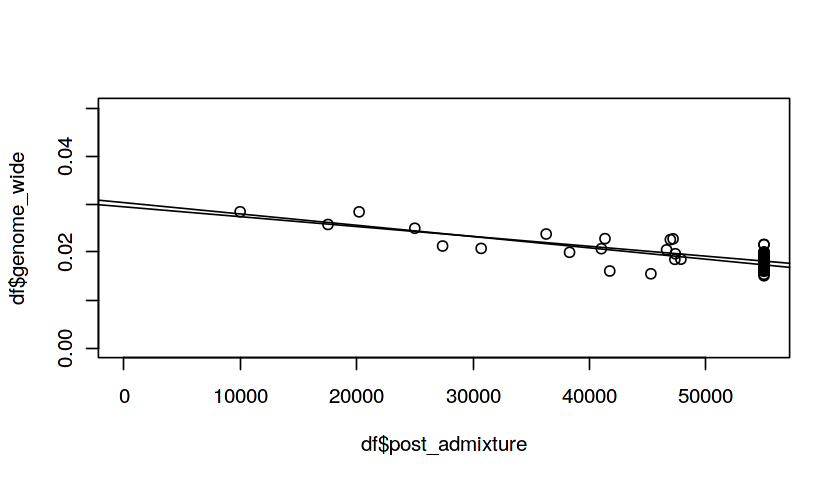

In [40]:
plot(df$post_admixture, df$genome_wide, ylim=c(0, 0.05), xlim=c(0, 55000))
abline(lin1)
abline(lin2)

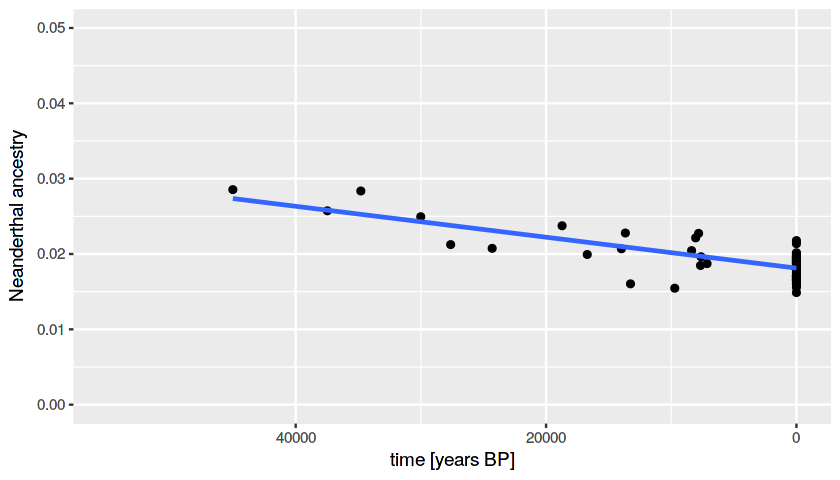

In [43]:
options(repr.plot.width=7, repr.plot.height=4)

filter(nea_cn, pop %in% c("EMH", "WestEurasia")) %>%
    ggplot(aes(age, genome_wide)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    scale_x_reverse(lim=c(55000, 0)) +
    labs(x="time [years BP]", y="Neanderthal ancestry")

## priPhCons in 100kb windows

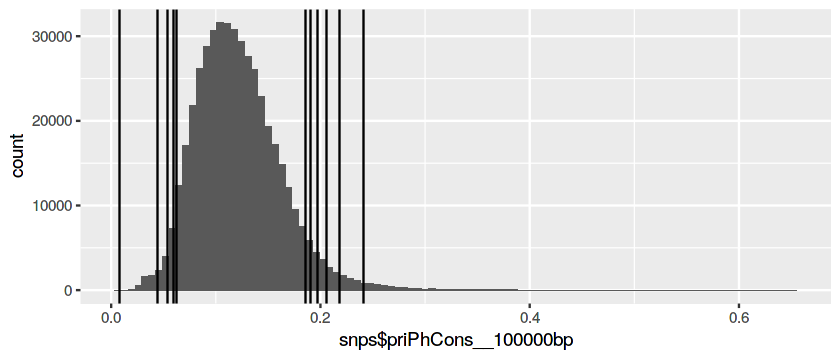

In [19]:
# B values
n_bins <- 100
cutoffs <- quantile(all_snps$priPhCons__100000bp,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
snps <- mutate(all_snps,
             bin=findInterval(priPhCons__100000bp, vec=cutoffs,
                              rightmost.closed=TRUE))

options(repr.plot.width=7, repr.plot.height=3)
qplot(snps$priPhCons__100000bp, bins=100) + geom_vline(xintercept=cutoffs[c(1:5, 95:100)])

In [20]:
calc_nea_in_bins <- function(snps, n_bins, sample_name) {
    sapply(seq_len(n_bins), function(i) {
        calc_sharing_prop(filter(snps, bin == i), "archaic_Altai", sample_name)
    }) %>% as_tibble %>% mutate(bin=as.factor(seq_len(n_bins))) %>% rename(nea=value)
}

nea_bins <- samples_info %>%
    mutate(priPhCons_bins=purrr::map(as.character(name), function(n) { calc_nea_in_bins(snps, n_bins, n)}))

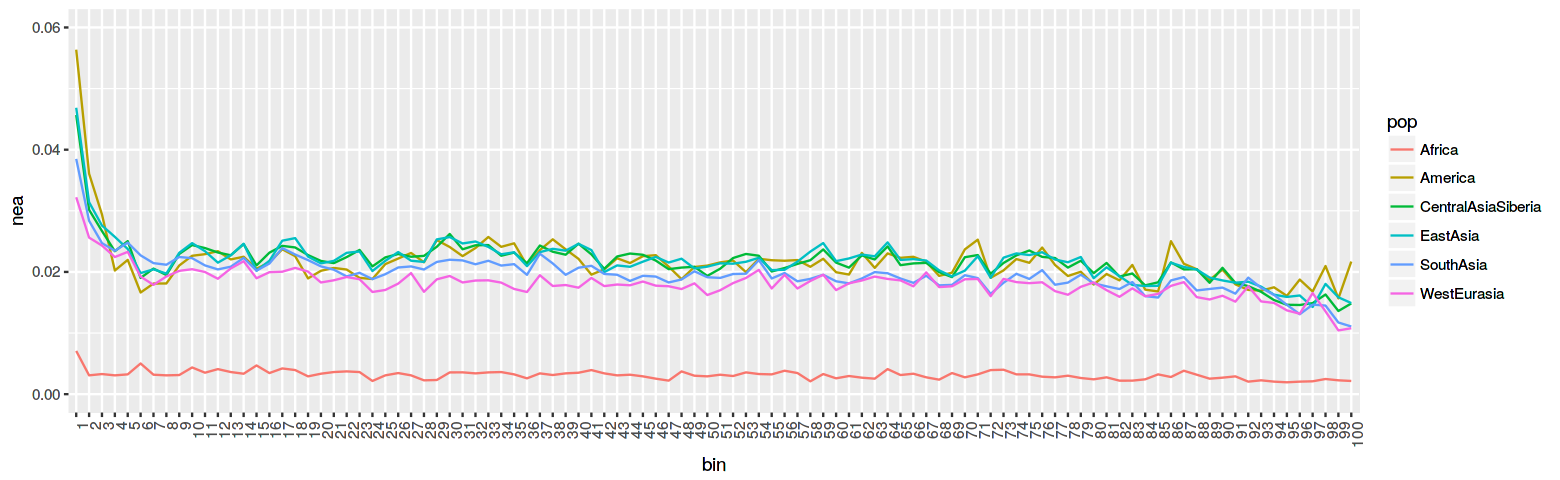

In [26]:
options(repr.plot.width=13, repr.plot.height=4)

unnest(nea_bins, priPhCons_bins) %>%
    filter(pop != "EMH",  pop != "Africa" | str_detect(name, "Yoruba|Dinka")) %>%
    group_by(pop, bin) %>% 
summarise(nea=mean(nea)) %>% 
ggplot(aes(bin, nea, group=pop, color=pop)) + geom_line() +
    coord_cartesian(ylim=c(0, 0.06)) +
    theme(axis.text.x=element_text(angle=90, hjust=1, size=9))

## B values in windows

Warning message:
"Removed 140 rows containing non-finite values (stat_bin)."

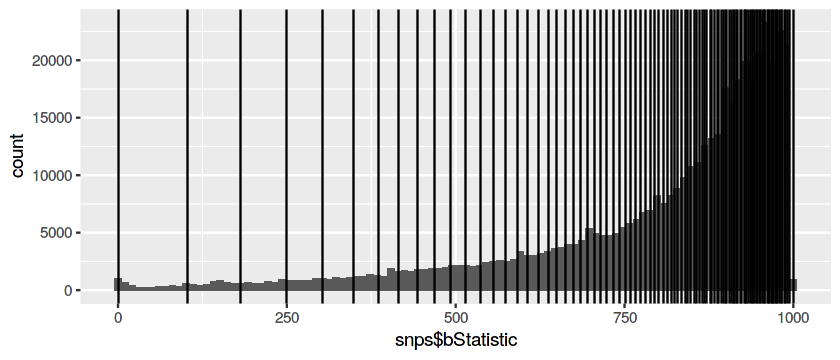

In [27]:
# B values
n_bins <- 100
cutoffs <- quantile(all_snps$bStatistic,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
snps <- mutate(all_snps,
             bin=findInterval(bStatistic, vec=cutoffs,
                              rightmost.closed=TRUE))

options(repr.plot.width=7, repr.plot.height=3)
qplot(snps$bStatistic, bins=100) + geom_vline(xintercept=cutoffs)

In [28]:
calc_nea_in_bins <- function(snps, n_bins, sample_name) {
    sapply(seq_len(n_bins), function(i) {
        calc_sharing_prop(filter(snps, bin == i), "archaic_Altai", sample_name)
    }) %>% as_tibble %>% mutate(bin=as.factor(seq_len(n_bins))) %>% rename(nea=value)
}

nea_bins %<>% mutate(bvalue_bins=purrr::map(as.character(name), function(n) { calc_nea_in_bins(snps, n_bins, n)}))

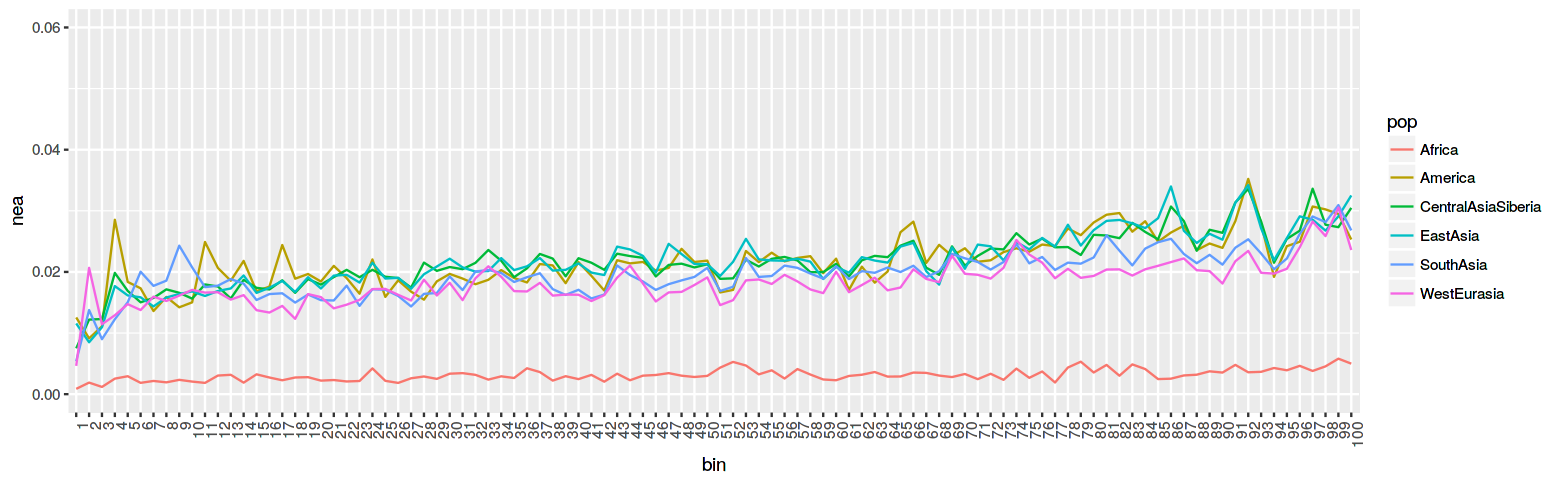

In [32]:
options(repr.plot.width=13, repr.plot.height=4)

unnest(nea_bins, bvalue_bins) %>%
    filter(pop != "EMH",  pop != "Africa" | str_detect(name, "Yoruba|Dinka")) %>%
    group_by(pop, bin) %>% 
summarise(nea=mean(nea)) %>% 
ggplot(aes(bin, nea, group=pop, color=pop)) + geom_line() +
    coord_cartesian(ylim=c(0, 0.06)) +
#  geom_smooth(method="lm", size=0.3, se=FALSE) +
    theme(axis.text.x=element_text(angle=90, hjust=1, size=9))

## Linear regression - B values

### Calculate Nea% per bin

Warning message:
"Removed 140 rows containing non-finite values (stat_bin)."

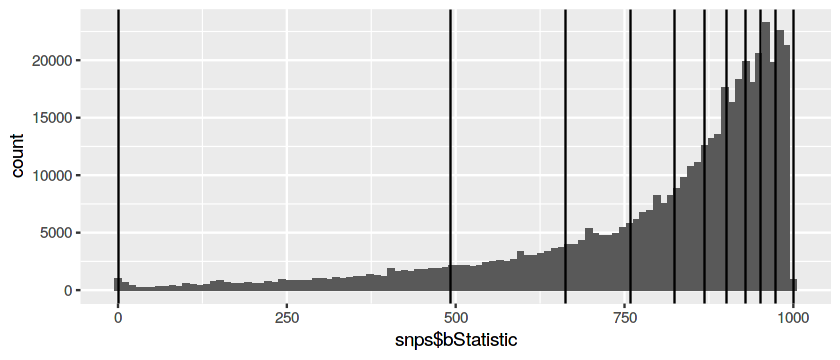

In [98]:
# B values
n_bins <- 10
cutoffs <- quantile(all_snps$bStatistic,
             prob=seq(0, 1, length.out=n_bins + 1),
             na.rm=TRUE)
snps <- mutate(all_snps,
             bin=findInterval(bStatistic, vec=cutoffs,
                              rightmost.closed=TRUE))

options(repr.plot.width=7, repr.plot.height=3)
qplot(snps$bStatistic, bins=100) + geom_vline(xintercept=cutoffs)

In [100]:
calc_nea_in_bins <- function(snps, n_bins, sample_name) {
    sapply(seq_len(n_bins), function(i) {
        calc_sharing_prop(filter(snps, bin == i), "archaic_Altai", sample_name)
    }) %>% as_tibble %>% mutate(bin=as.factor(seq_len(n_bins))) %>% rename(nea=value)
}

nea_bins <- samples_info %>%
    mutate(bins=purrr::map(as.character(name), function(n) { calc_nea_in_bins(snps, n_bins, n)}))

### Nea% in each bin aggregated by a population

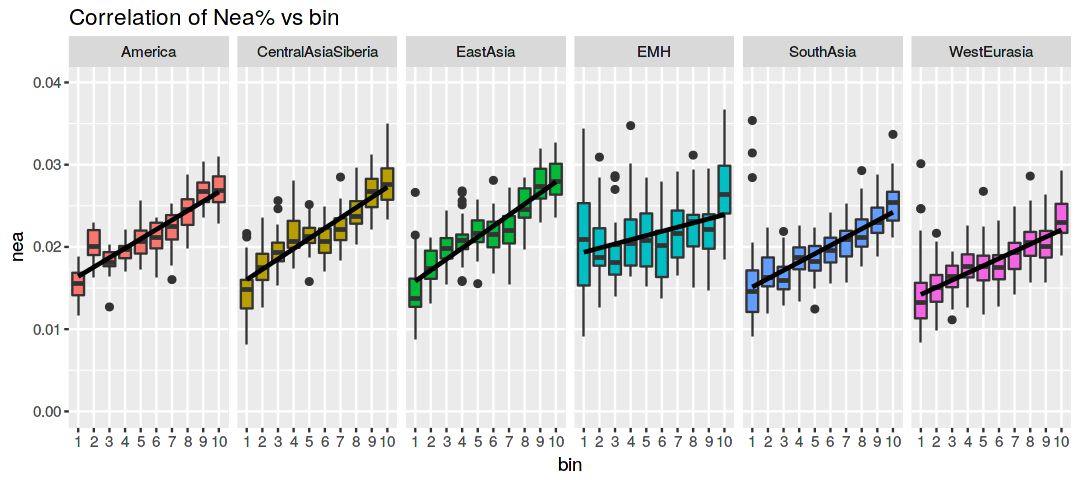

In [101]:
options(repr.plot.width=9, repr.plot.height=4)

# boxplots of Nea% per bin in each population
unnest(nea_bins, bins) %>% filter(pop != "Africa") %>%
  {
      ggplot(., aes(bin, nea, fill=pop, group=bin)) +
          geom_boxplot() +
          geom_smooth(method="lm", se=FALSE, color="black", aes(group=pop)) +
          coord_cartesian(ylim=c(0, 0.04)) +
          ggtitle(paste("Correlation of Nea% vs bin ")) +
          theme(legend.position="none") +
          facet_grid(. ~ pop)
  } %>% print

### Nea% in each bin aggregated by a population - per individual

### Nea% in each bin aggregated by a population - per individual

## Linear regression metrics

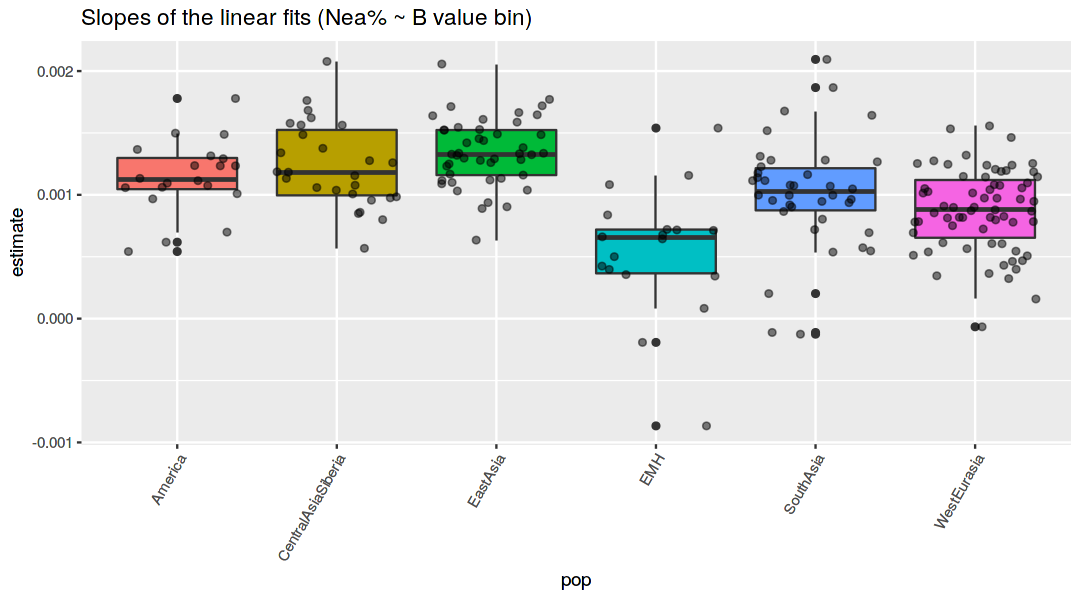

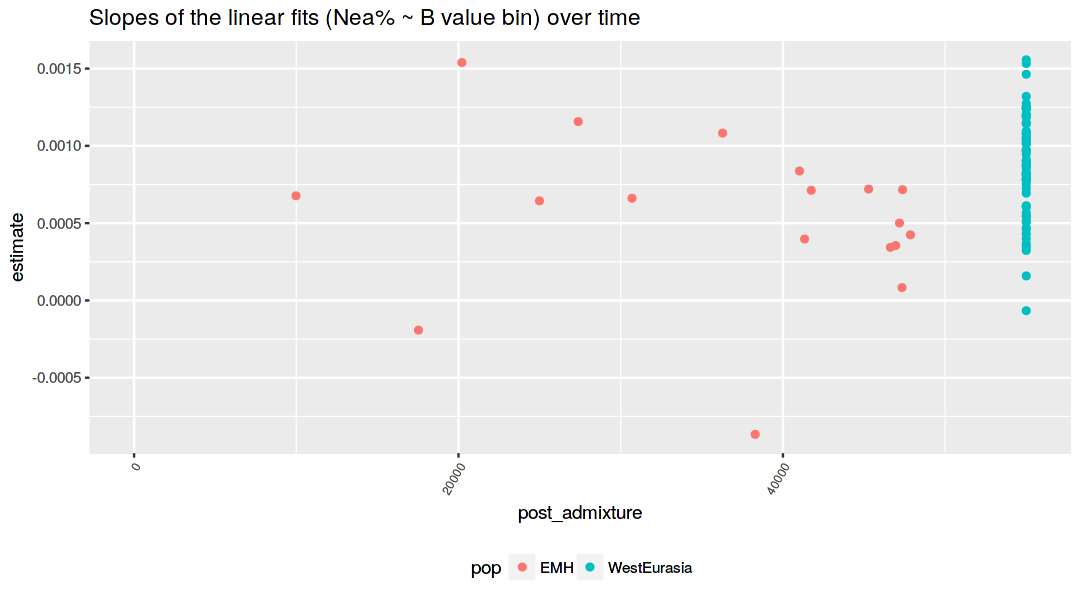

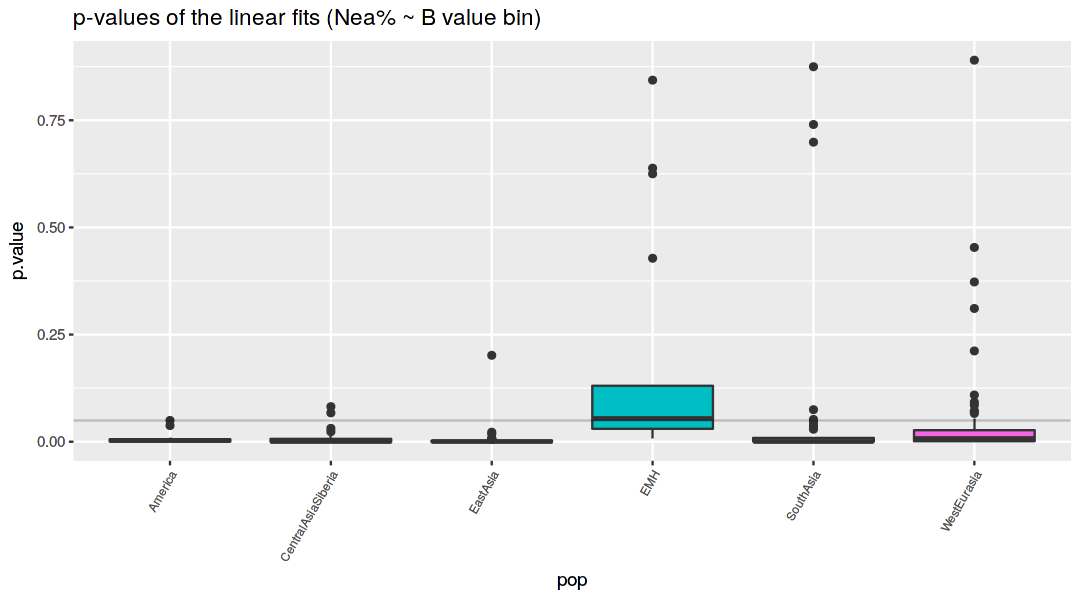

In [22]:
options(repr.plot.width=9, repr.plot.height=5)

nea_bin_lm <- function(df) {
  lm(nea ~ bin, data=mutate(df, bin=as.integer(bin)))
}

lm_per_sample <- nea_bins %>%
  unnest %>%
  filter(pop != "Africa") %>%
  group_by(name, pop, post_admixture) %>%
  nest %>%
  mutate(model=map(data, nea_bin_lm),
         glance=map(model, glance),
         tidy=map(model, tidy))

# plot the distribution of slopes in each pop
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin") %>%
  ggplot(aes(pop, estimate, fill=pop)) +
  geom_boxplot() +
  geom_jitter(alpha=1/2) +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position="none")

# plot the slopes over time
unnest(lm_per_sample, tidy) %>%
  filter(term == "bin", pop == "EMH" | pop == "WestEurasia") %>%
  ggplot(aes(post_admixture, estimate, colour=pop)) +
  geom_point() +
  ggtitle("Slopes of the linear fits (Nea% ~ B value bin) over time") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="bottom") +
  xlim(0, 55000)

# plot the p.value of each fit
unnest(lm_per_sample, glance, .drop=TRUE) %>%
  ggplot(aes(pop, p.value, fill=pop)) +
  geom_boxplot() +
  geom_hline(yintercept=0.05, alpha=1/5) +
  ggtitle("p-values of the linear fits (Nea% ~ B value bin)") +
  theme(axis.text.x=element_text(angle=60, hjust=1, size=7),
        legend.position="none")

In [13]:
library(maps)


Attaching package: 'maps'

The following object is masked from 'package:purrr':

    map



## Genome-wide Nea%

In [14]:
nea_est <- samples_info %>%
    mutate(nea=sapply(as.character(name), function(n) { calc_sharing_prop(all_snps, "archaic_Altai", n)}))

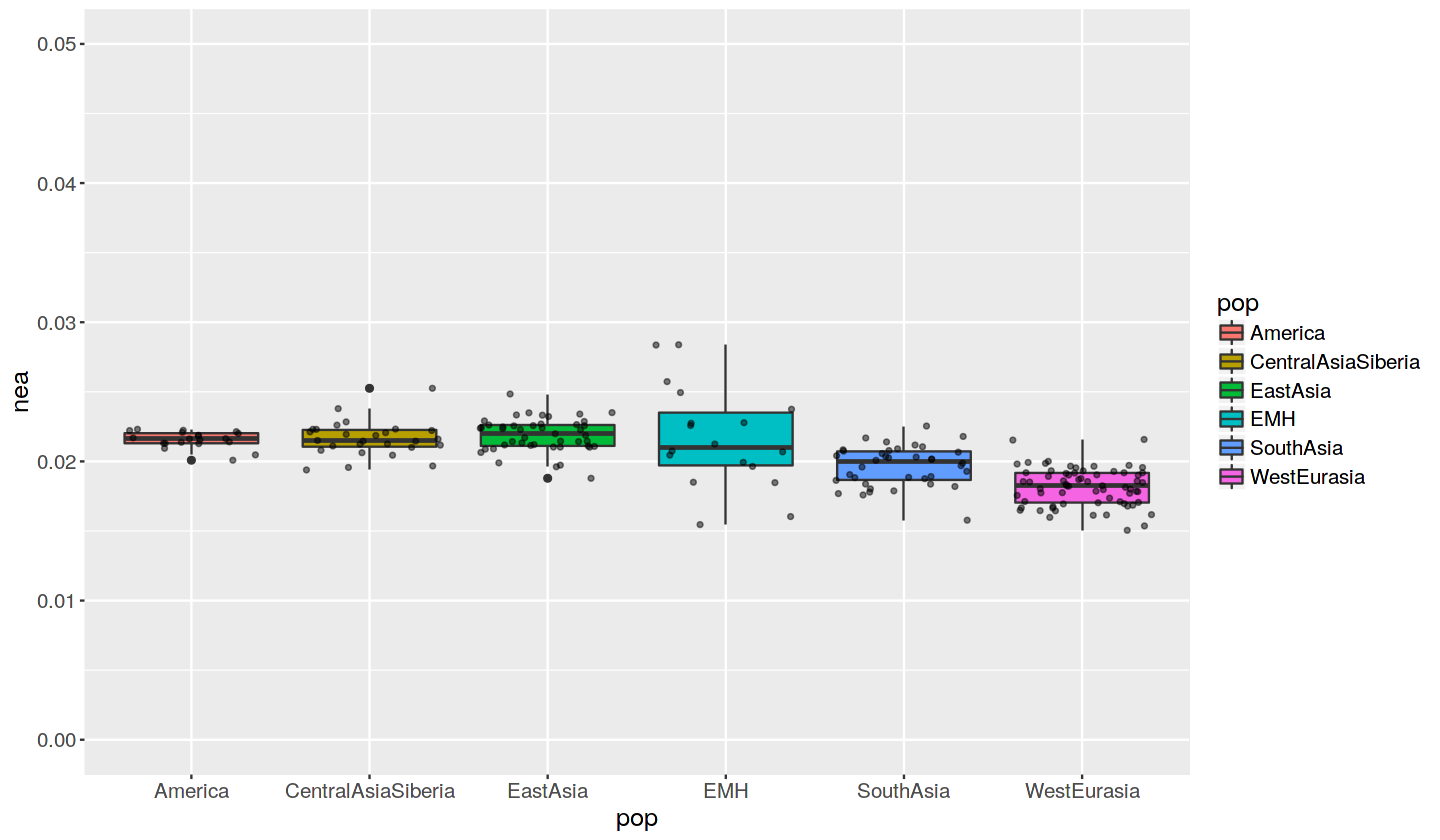

In [15]:
options(repr.plot.width=12, repr.plot.height=7)

filter(nea_est, pop != "Africa") %>%
ggplot() +
  geom_boxplot(aes(pop, nea, fill=pop)) +
  geom_jitter(aes(pop, nea), size=1, alpha=1/2) +
  coord_cartesian(ylim=c(0, 0.05)) +
  theme(text=element_text(size=15),
        legend.position="right")

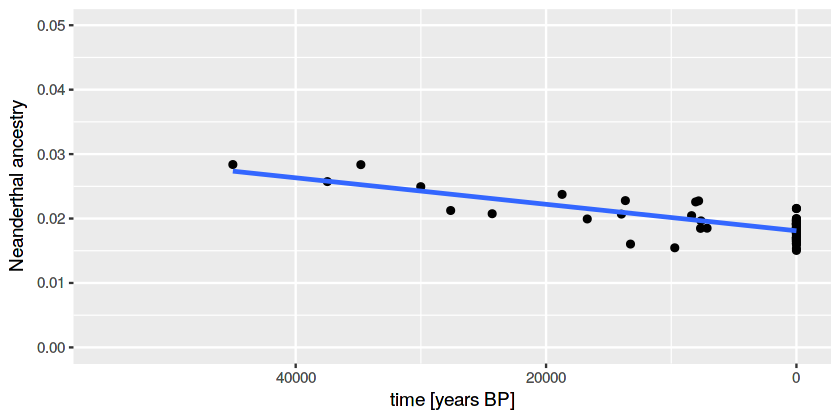

In [22]:
options(repr.plot.width=7, repr.plot.height=3.5)

filter(nea_est, pop %in% c("EMH", "WestEurasia")) %>%
    ggplot(aes(age, nea)) +
    geom_point() +
    geom_smooth(method="lm", se=FALSE) +
    ylim(0, 0.05) +
    scale_x_reverse(lim=c(55000, 0)) +
    labs(x="time [years BP]", y="Neanderthal ancestry")

Warning message:
"Removed 18 rows containing missing values (geom_point)."

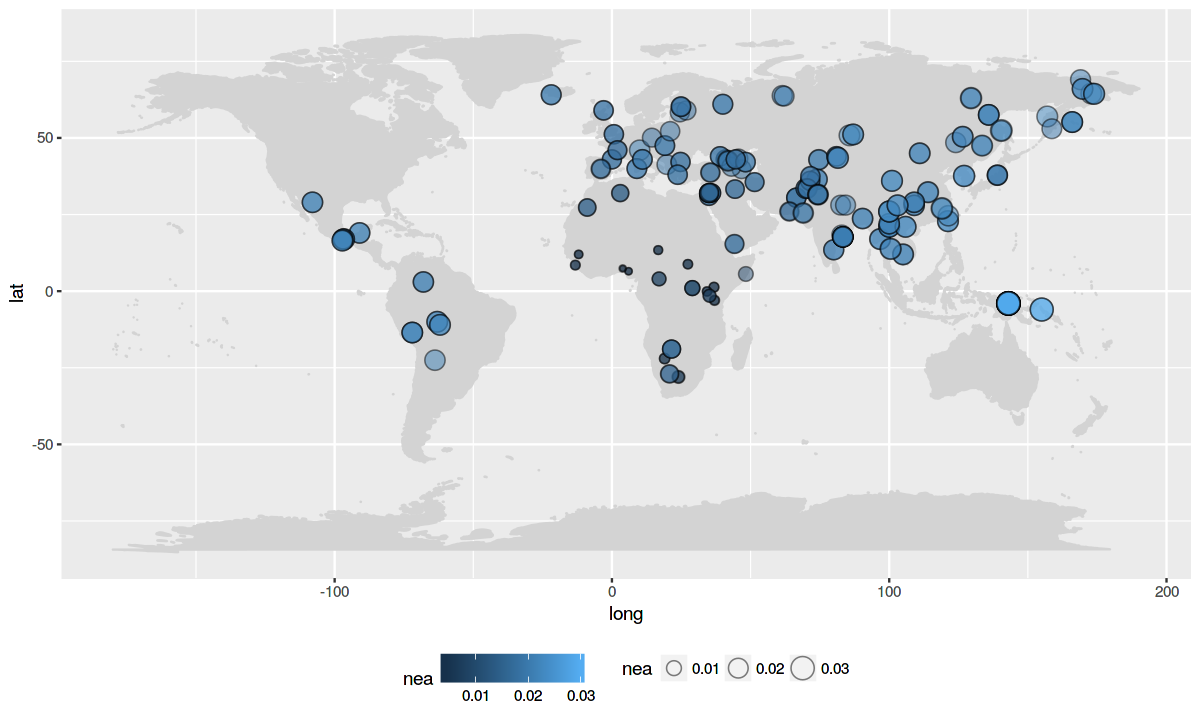

In [18]:
options(repr.plot.width=10, repr.plot.height=6)

map_plot <-
    map_data("world") %>%
    ggplot() +
    geom_polygon(aes(x=long, y=lat, group=group), 
                 colour="light gray", fill="light gray")

map_plot +
    geom_point(data=nea_est, 
               aes(Longitude, Latitude, fill=nea, size=nea), pch=21, alpha=1/2) +
    theme(legend.position="bottom")